# Context aware gate calibration notebook

This notebook proposes a full demonstration of how to use the context-aware gate calibration, leveraging only gate parameters.
Another notebook is available if one wants to deal with pulse level calibration.

In [1]:
path = "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control"

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import sys

module_path = os.path.abspath(os.path.join(path))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Qiskit imports
from qiskit import pulse, transpile
from qiskit.transpiler import InstructionDurations
from qiskit.circuit import (
    ParameterVector,
    QuantumCircuit,
    QuantumRegister,
    Gate,
    ParameterExpression,
    CircuitInstruction,
)

from qiskit_ibm_runtime.options import SimulatorOptions, TranspilationOptions
from qiskit.providers import Backend
from qiskit.providers.fake_provider import (
    FakeJakartaV2,
    FakeJakarta,
    FakeHanoi,
    FakePerth,
)
from qiskit_aer import AerSimulator
from qiskit.circuit.library import XGate, CXGate

from qconfig import QiskitConfig

from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from gymnasium.spaces import Box, Space
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.distributions import Normal

import numpy as np
import tqdm
import time
from typing import Union, Optional, List, Sequence
from IPython.display import clear_output

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


# Circuit macros for environment

In [4]:
def param_circuit(
    qc: QuantumCircuit,
    params: Optional[ParameterVector] = None,
    q_reg: Optional[QuantumRegister] = None,
) -> None:
    my_qc = QuantumCircuit(q_reg, name="custom_cx")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])

    my_qc.u(
        optimal_params[0] + params[0],
        optimal_params[1] + params[1],
        optimal_params[2] + params[2],
        q_reg[0],
    )
    my_qc.u(
        optimal_params[3] + params[3],
        optimal_params[4] + params[4],
        optimal_params[5] + params[5],
        q_reg[1],
    )
    my_qc.rzx(optimal_params[6] + params[6], q_reg[0], q_reg[1])
    # my_qc.u(np.pi *params[0], np.pi *params[1], np.pi *params[2], 0)
    # my_qc.u(np.pi *params[3], np.pi *params[4], np.pi *params[5], 1)
    # my_qc.rzx(np.pi * params[6], 0, 1)
    qc.append(my_qc.to_instruction(label="custom_cx"), physical_qubits)
    # qc.rx(2 * np.pi * params[0], physical_qubits)

# Definition of QuantumEnvironment

## Generic information characterizing the quantum system

The algorithm is built upon Qiskit modules. To specify how to address our quantum system of interest, we therefore adopt the IBM approach to define a quantum backend, on which qubits are defined and can be accessed via control actions and measurements.

The cell below specifies:
- ```sampling_Paulis```: number of Pauli observables  to be sampled from the system: the algorithm relies on the ability to process measurement outcomes to estimate the expectation value of different Pauli operators. The more observables we provide for sampling, the more properties we are able to deduce with accuracy about the actual state that was created when applying our custom controls. For a single qubit, the possible Pauli operators are $\sigma_0=I$, $\sigma_x=X$, $\sigma_y=Y$, $\sigma_z=Z$. For a general multiqubit system, the Pauli observables are tensor products of those single qubit Pauli operators. The algorithm will automatically estimate which observables are the most relevant to sample based on the provided target. The probability distribution from which those observables are sampled is derived from the Direct Fidelity Estimation (equation 3, https://link.aps.org/doi/10.1103/PhysRevLett.106.230501) algorithm. 
- ```N_shots```: Indicates how many measurements shall be done for each provided circuit (that is a specific combination of an action vector and a Pauli observable to be sampled)
- ```n_actions```: Indicates the number of pulse/circuit parameters that characterize our parametrized quantum circuit. For our pulse level ansatz, this number will depend on the number of parameters we are willing to tune in the original two-qubit gate calibration. For now we set it to 0, but will use the function ```count_parameters``` above to determine the number.
- ```estimator_options```: Options of the Qiskit Estimator primitive. The Estimator is the Qiskit module enabling an easy computation of Pauli expectation values. One can set options to make this process more reliable (typically by doing some error mitigation techniques in post-processing). Works only with Runtime Backend at the moment
- ```abstraction_level``` chosen to encode our quantum circuit. One can choose here to stick to the usual circuit model of quantum computing, by using the ```QuantumCircuit``` objects from Qiskit and therefore set the ```abstraction_level``` to ```"circuit"```. However, depending on the task at hand, one can also prefer to use a pulse description of all the operations in our circuit. This is possible for both real backends and simulators by using respectively Qiskit Runtime and Qiskit Dynamics. In this case, one should define the ansatz circuit above in a pulse level fashion, and the simulation done at the Hamiltonian level, and not only via statevector calculations. In this notebook we set the ```abstraction_level``` to ```"gate"```. Another notebook at the pulse level is available in the repo.

In [5]:
from qiskit_ibm_runtime import Options

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
physical_qubits = [0, 1]
sampling_Paulis = 200
N_shots = 20  # Number of shots for sampling the quantum computer for each action vector
n_actions = 7  # Choose how many control parameters in pulse/circuit parametrization
batchsize = 300
seed = 10
estimator_options = Options()

min_bound_actions = -0.05
max_bound_actions = 0.05
scale_factor = 0.05
observation_space = Box(
    low=np.array([0, 0]),
    high=np.array([1, tgt_instruction_counts]),
    shape=(2,),
    seed=seed,
)
action_space = Box(
    low=min_bound_actions, high=max_bound_actions, shape=(n_actions,), seed=seed
)

## Setting up Quantum Backend

### Simulation backend initialization
If you want to run the algorithm over a simulation, you can use both local (Qiskit Aer module or statevector simulation) and cloud simulators from IBM (Qiskit Runtime).

Below we define a gate level simulator instance mimicking a FakeBackend object. It can be either defined on the IBM cloud or locally.



#### Using ```FakeBackend``` as starting point

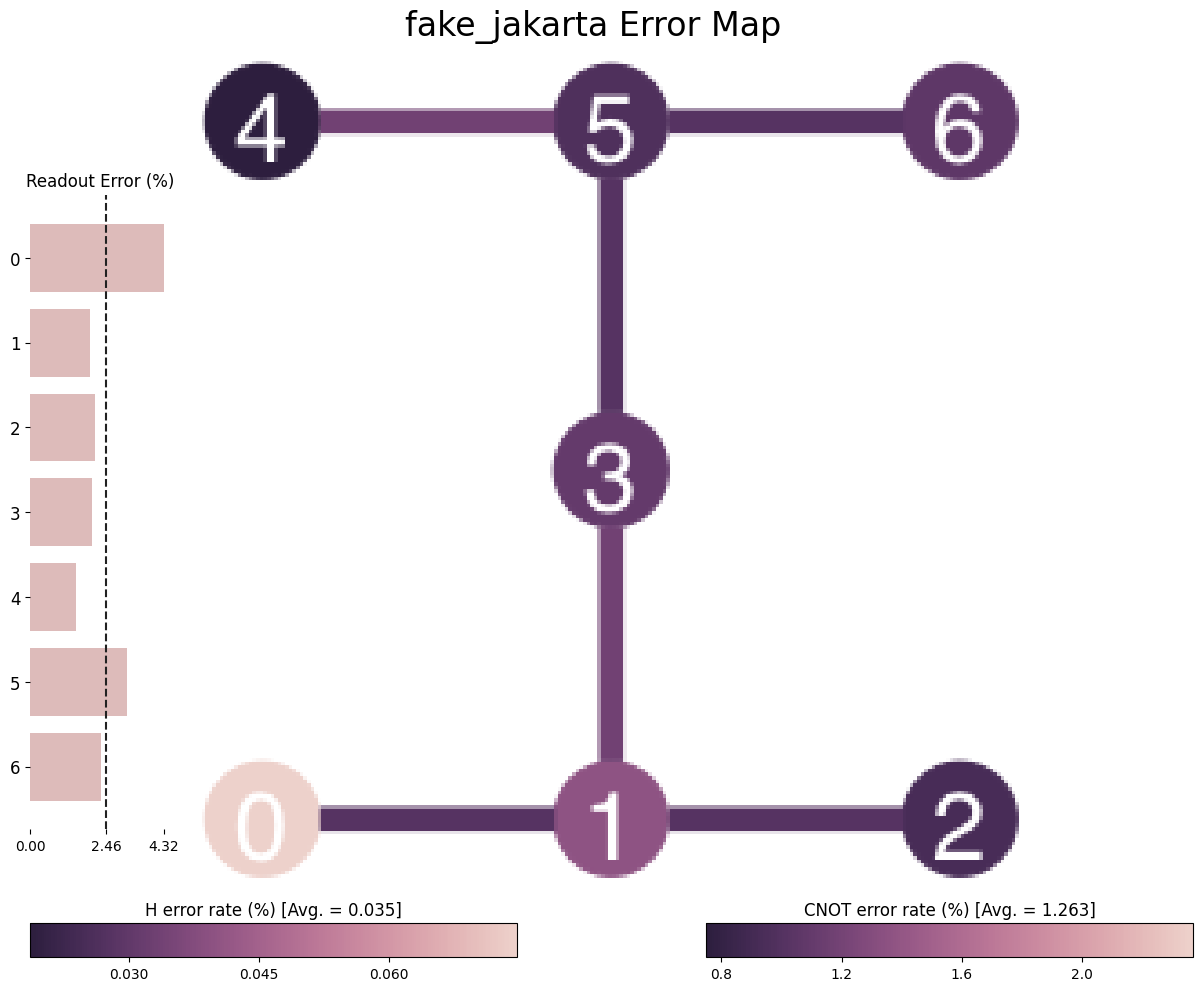

In [6]:
from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta, FakeJakartaV2
from qiskit.visualization import (
    plot_coupling_map,
    plot_circuit_layout,
    gate_map,
    plot_gate_map,
    plot_error_map,
)
from qiskit.visualization.pulse_v2 import IQXDebugging

fake_backend = FakeJakarta()
fake_backend_v2 = FakeJakartaV2()
plot_error_map(fake_backend)

#### Choose Runtime Backend (Simulator or Real)

Below, you can choose to run the simulations on IBM cloud instead of using the local Qiskit-Aer module. 

*IMPORTANT*: The circuit context module requires the ability to schedule the instructions in a precise timing, in order to identify clearly how to build circuit truncations enabling the sequence of gate calibrations that should be done in context.
To enable the execution on IBM cloud, it is therefore necessary to update the ```InstructionDurations``` argument of the simulator backend with a user-defined one (or alternatively one from a ```FakeBackend``` object).

In [7]:
# Cloud simulator backend
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel="ibm_quantum", instance="ibm-q-nus/default/default"
)
runtime_backend = service.backend("ibmq_qasm_simulator")
estimator_options.simulator.set_backend(fake_backend_v2)

# # To run in context calibration, we need to update the following attribute
runtime_backend.instruction_durations.update(fake_backend_v2.instruction_durations)

## Choose backend and define Qiskit config dictionary
Below, set the Backend that you would like to run among the above defined backend.
Then define the config gathering all the components enabling the definition of the ```QuantumEnvironment```.



In [8]:
# Choose backend: local or in the cloud (runtime_backend or fake_backend_v2)
backend = fake_backend_v2

In [9]:
config = QiskitConfig(
    parametrized_circuit=param_circuit,
    backend=backend,
    estimator_options=estimator_options,
)

In [10]:
from dataclasses import asdict

print("Estimator options:")
asdict(estimator_options)

Estimator options:


{'optimization_level': None,
 'resilience_level': None,
 'max_execution_time': None,
 'transpilation': {'skip_transpilation': False,
  'initial_layout': None,
  'layout_method': None,
  'routing_method': None,
  'approximation_degree': None},
 'resilience': {'noise_amplifier': None,
  'noise_factors': None,
  'extrapolator': None},
 'execution': {'shots': 4000, 'init_qubits': True},
 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []},
 'simulator': {'noise_model': <NoiseModel on ['id', 'sx', 'cx', 'x', 'reset', 'measure']>,
  'seed_simulator': None,
  'coupling_map': <qiskit.transpiler.coupling.CouplingMap at 0x2c36d8f40>,
  'basis_gates': ['id', 'rz', 'sx', 'x', 'cx', 'reset', 'measure', 'delay']}}

## Target gate definition

Below we provide the necessary elements to define a target instruction to be calibrated within a specific circuit context. 

To do so we need:
1. A target gate, which we will pick as the CNOT gate, and a list of ```physical qubits``` on which it is applied. The algorithm will identify the ```CircuitInstruction``` object that is formed by the application of the gate on the specific set of qubits (that means that it will not calibrate instances of the gate on another set of qubits, an extension will enable in the future the simultaneous calibration of a target gate on non-overlapping qubits).
2. A ```QuantumCircuit``` instance involving the call of such gate.

*IMPORTANT*: To make sure that the gate we want to optimize will indeed be present in the transpiled circuit, make sure to first transpile the circuit yourself (with the method of your choice) before feeding the ```TorchQuantumEnvironment``` with it.

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


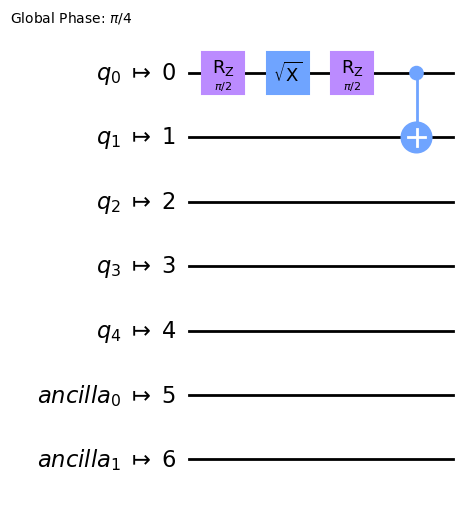

In [11]:
target_gate = CXGate()
target = {"gate": target_gate, "register": physical_qubits}

target_circuit = QuantumCircuit(5)

target_circuit.h(0)
target_circuit.cx(0, 1)

target_circuit = transpile(target_circuit, backend, optimization_level=1)
target_circuit.draw("mpl")

# Definition of ```TorchQuantumEnvironment```

Below we define our custom ```ContextAwareQuantumEnvironment``` to perform contextual gate calibration.


QuantumEnvironment composed of 2 qubits, 
Defined target: gate (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]))
Physical qubits: [0, 1]
Backend: <qiskit.providers.fake_provider.backends.jakarta.fake_jakarta.FakeJakartaV2 object at 0x2bc8a5090>,
Abstraction level: circuit,
Run options: N_shots (20), Sampling_Pauli_space (200), 

In [13]:
from qiskit.circuit import CircuitInstruction
from typing import Dict


def retrieve_tgt_instruction_count(qc: QuantumCircuit, target: Dict):
    tgt_instruction = CircuitInstruction(
        target["gate"], [qc.qubits[i] for i in target["register"]]
    )
    return qc.data.count(tgt_instruction)

In [14]:
# Define necessary information for the Torch wrapper
tgt_instruction_counts = retrieve_tgt_instruction_counts(target_circuit, target)
training_steps_per_gate = (
    3  # How many training iterations allocated for each target gate in circuit
)
benchmark_cycle = 10

optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])

torch_env = TorchQuantumEnvironment(
    q_env,
    target_circuit,
    action_space,
    observation_space,
    batch_size=batchsize,
    training_steps_per_gate=training_steps_per_gate,
    benchmark_cycle=benchmark_cycle,
    intermediate_rewards=False,
    seed=None,
)
torch_env

Basis gate Library for CX gate not yet available, will be transpiled over ECR basis gate


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


QuantumEnvironment composed of 2 qubits, 
Defined target: gate (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]))
Physical qubits: [0, 1]
Backend: <qiskit.providers.fake_provider.backends.jakarta.fake_jakarta.FakeJakartaV2 object at 0x2bc8a5090>,
Abstraction level: circuit,
Run options: N_shots (20), Sampling_Pauli_space (200), 
Batchsize: 250, 
Number of target gates in circuit context: 1

In [15]:
tgt_instruction_counts

1

In [16]:
print("Backend options:\n", backend.options)

Backend options:
 Options(shots=1024, method='automatic', device='CPU', precision='double', executor=None, max_job_size=None, max_shot_size=None, enable_truncation=True, zero_threshold=1e-10, validation_threshold=None, max_parallel_threads=None, max_parallel_experiments=None, max_parallel_shots=None, max_memory_mb=None, fusion_enable=True, fusion_verbose=False, fusion_max_qubit=None, fusion_threshold=None, accept_distributed_results=None, memory=None, noise_model=None, seed_simulator=None, cuStateVec_enable=False, blocking_qubits=None, blocking_enable=False, chunk_swap_buffer_qubits=None, batched_shots_gpu=False, batched_shots_gpu_max_qubits=16, num_threads_per_device=1, shot_branching_enable=False, shot_branching_sampling_enable=False, statevector_parallel_threshold=14, statevector_sample_measure_opt=10, stabilizer_max_snapshot_probabilities=32, extended_stabilizer_sampling_method='resampled_metropolis', extended_stabilizer_metropolis_mixing_time=5000, extended_stabilizer_approximatio

In [17]:
print("Updated estimator options to account for the context:\n")
print(torch_env.estimator.options)

Updated estimator options to account for the context:

Options()


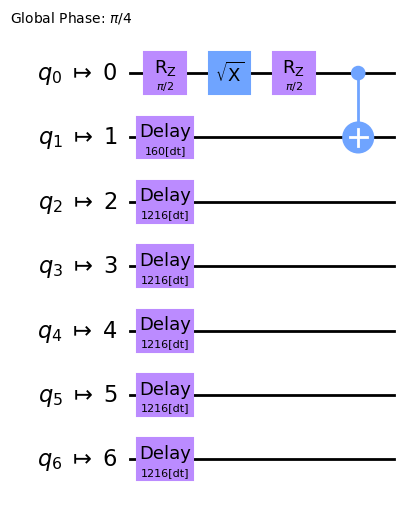

In [18]:
torch_env.circuit_context.draw("mpl")

In [19]:
torch_env.circuit_truncations[2].draw("mpl")

IndexError: list index out of range

# Definition of the Agent

In [20]:
from agent import ActorNetwork, CriticNetwork, Agent

hidden_units = [64, 64]
activation_functions = [nn.Tanh(), nn.Tanh(), nn.Tanh()]
include_critic = True
chkpt_dir = "tmp/ppo"
chkpt_dir_critic = "tmp/critic_ppo"

actor_net = ActorNetwork(
    observation_space,
    hidden_units,
    n_actions,
    activation_functions,
    include_critic,
    chkpt_dir,
).to(device)
critic_net = CriticNetwork(
    observation_space, hidden_units, activation_functions, chkpt_dir_critic
).to(device)
agent = Agent(actor_net, critic_net=None).to(device)

## Hyperparameters for training

In [21]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""
run_name = "test"
writer = SummaryWriter(f"runs/{run_name}")
# writer.add_text(
#     "hyperparameters",
#     "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
# )
# Hyperparameters for the agent
n_epochs = 10  # Number of epochs : default 1500
num_updates = 1000
opti = "Adam"
lr_actor = 0.0001  # Learning rate for policy update step
lr_critic = 0.0018  # Learning rate for critic (value function) update step

epsilon = 0.2  # Parameter for clipping value (PPO)
critic_loss_coeff = 0.5
optimizer = optim.Adam(agent.parameters(), lr=lr_actor, eps=1e-5)
actor_optimizer = optim.Adam(actor_net.parameters(), lr=lr_actor, eps=1e-5)
critic_optimizer = optim.Adam(critic_net.parameters(), lr=lr_critic, eps=1e-5)
minibatch_size = 40
gamma = 1.0
gae_lambda = 0.95

# Clipping
clip_vloss = True
grad_clip = 0.5
clip_coef = 0.5
normalize_advantage = False

# other coefficients
ent_coef = 0.0

# Training
## Storage setup

In [22]:
global_step = 0
torch_env.clear_history()
obs = torch.zeros(
    (tgt_instruction_counts, batchsize) + torch_env.observation_space.shape
).to(device)
actions = torch.zeros(
    (tgt_instruction_counts, batchsize) + torch_env.action_space.shape
).to(device)
logprobs = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
rewards = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
dones = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
values = torch.zeros((tgt_instruction_counts, batchsize)).to(device)

train_obs = torch.zeros(
    (batchsize,) + torch_env.observation_space.shape, requires_grad=True
).to(device)
visualization_steps = 10

## Main loop

In [23]:
%load_ext tensorboard
%tensorboard --logdir runs

Launching TensorBoard...

In [24]:
from tensorboard import notebook

notebook.list()  # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir runs (started 0:00:01 ago; pid 10837)


In [25]:
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir runs (started 0:00:01 ago; port 6006, pid 10837).


In [33]:
for update in tqdm.tqdm(range(1, num_updates + 1)):
    next_obs, _ = torch_env.reset(seed=seed)
    num_steps = torch_env.episode_length(global_step)
    next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
    next_done = torch.zeros(batchsize).to(device)

    # print("episode length:", num_steps)

    for step in range(num_steps):
        global_step += 1
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            mean_action, std_action, critic_value = agent(next_obs)
            mean_action *= scale_factor
            probs = Normal(mean_action, std_action)
            action = torch.clip(
                probs.sample(),
                torch.Tensor(np.array(min_bound_actions)),
                torch.Tensor(np.array(max_bound_actions)),
            )
            logprob = probs.log_prob(action).sum(1)
            values[step] = critic_value.flatten()

        actions[step] = action
        logprobs[step] = logprob
        # next_obs, reward, terminated, truncated, infos = torch_env.step(action.cpu().numpy())
        next_obs, reward, terminated, truncated, infos = torch_env.step(
            action.cpu().numpy()
        )
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device)
        next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
        next_done = torch.Tensor(np.array([int(done)] * batchsize)).to(device)
        # Only print when at least 1 env is done

        # print(f"global_step={global_step}, episodic_return={np.mean(reward)}")
        writer.add_scalar("charts/episodic_return", np.mean(reward), global_step)
        writer.add_scalar("charts/episodic_length", num_steps, global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = (
                delta + gamma * gae_lambda * nextnonterminal * lastgaelam
            )
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + torch_env.observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + torch_env.action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batchsize)
    clipfracs = []
    for epoch in range(n_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batchsize, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]
            new_mean, new_sigma, new_value = agent(b_obs[mb_inds])
            new_dist = Normal(new_mean, new_sigma)
            new_logprob, entropy = new_dist.log_prob(b_actions[mb_inds]).sum(
                1
            ), new_dist.entropy().sum(1)
            logratio = (
                new_logprob - b_logprobs[mb_inds] + torch.log(torch.Tensor([1e-6]))
            )
            ratio = logratio.exp()
            # print('new_logprob', new_logprob)
            # print('b_logprobs[mb_inds]', b_logprobs[mb_inds])
            # print("logratio", logratio)
            # print('ratio', ratio)
            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > epsilon).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if normalize_advantage:  # Normalize advantage
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (
                    mb_advantages.std() + 1e-8
                )

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = new_value.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * critic_loss_coeff

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), grad_clip)
            optimizer.step()

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
    print("mean", mean_action[0])
    print("sigma", std_action[0])
    print("Average return:", np.mean(torch_env.reward_history, axis=1)[-1])
    # print(np.mean(torch_env.reward_history, axis =1)[-1])
    if torch_env.do_benchmark():
        print("Circuit fidelity:", torch_env.circuit_fidelity_history[-1])
        print("Avg gate fidelity:", torch_env.avg_fidelity_history[-1])
        for i in range(num_steps):
            writer.add_scalar(
                f"losses/avg_gate_{i}_fidelity",
                torch_env.avg_fidelity_history[-1][i],
                global_step,
            )
        writer.add_scalar(
            "losses/circuit_fidelity",
            torch_env.circuit_fidelity_history[-1],
            global_step,
        )
    print(torch_env._get_info())
    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar(
        "charts/learning_rate", optimizer.param_groups[0]["lr"], global_step
    )
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar(
        "losses/avg_return", np.mean(torch_env.reward_history, axis=1)[-1], global_step
    )

    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    if global_step % visualization_steps == 0:
        clear_output(wait=True)  # for animation

torch_env.close()
writer.close()

100%|██████████| 1000/1000 [01:35<00:00, 10.45it/s]


In [34]:
torch_env.close()
writer.close()

In [35]:
torch_env._get_info()["observable"]

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j])

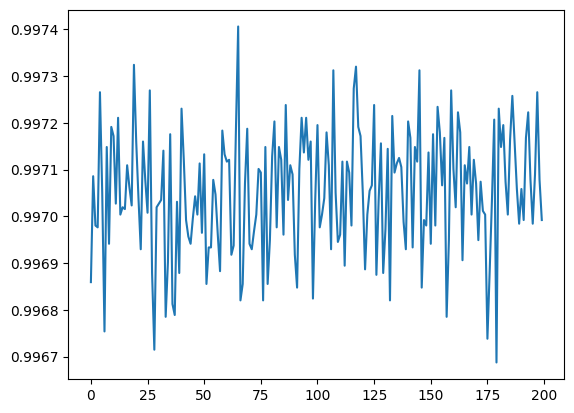

In [36]:
import matplotlib.pyplot as plt

plt.plot(torch_env.circuit_fidelity_history)

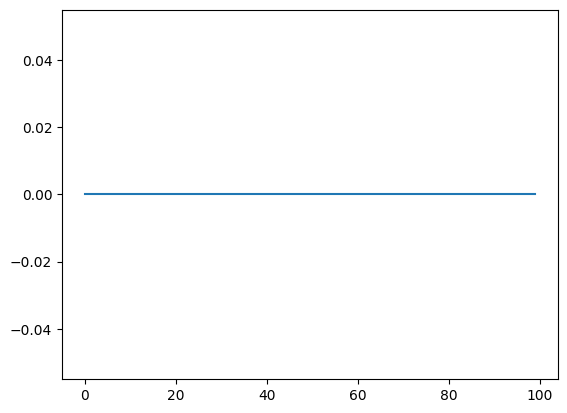

In [30]:
plt.plot(torch_env.avg_fidelity_history)

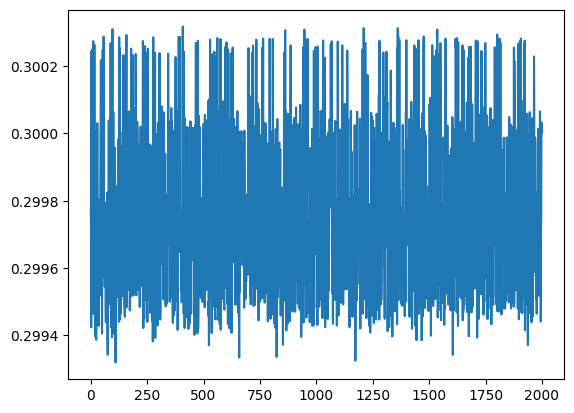

In [37]:
plt.plot(np.mean(torch_env.reward_history, axis=1))

In [32]:
from qiskit.quantum_info import Operator, average_gate_fidelity
from qiskit.circuit.library.standard_gates import CXGate

my_qc = QuantumCircuit(2, name="custom_cx")
optimal_params = [0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5]
params = [-0.0062, 0.2190, 0.9921, 0.9924, -0.9921, 0.9910, -0.9907]
my_qc.u(np.pi * params[0], np.pi * params[1], np.pi * params[2], 0)
my_qc.u(np.pi * params[3], np.pi * params[4], np.pi * params[5], 1)
my_qc.rzx(np.pi * params[6], 0, 1)
average_gate_fidelity(Operator(my_qc), Operator(CXGate()))

0.20009201464808402

In [ ]:
mean
tensor([0.0706, -0.0553, 0.0329, 0.0496, -0.1285, 0.1071, 0.1628])
sigma
tensor([0.4565, 0.4977, 0.5308, 0.5297, 0.4840, 0.5090, 0.5176])